In [1]:
import json
from datetime import datetime, timedelta
import pandas as pd
import seaborn as sns
import numpy as np
from itertools import groupby
from operator import itemgetter
from matplotlib import pyplot as plt

In [2]:
#annot_file = r"C:\Users\Josh\Downloads\project-64-at-2022-01-26-20-30-21909fe6.json"
#annot_file = r"C:\Users\Josh\Downloads\project-64-at-2022-02-08-20-42-d412803b.json"
#annot_file = r"C:\Users\Josh\Downloads\project-64-at-2022-02-11-23-47-09a432dd.json"
annot_file = r"C:\Users\Josh\Downloads\project-3-at-2022-06-10-21-34-9e16185b.json"

In [3]:
def get_image_path(entry: dict) -> str:
    ''' Extract image file path from an annotation entry
    '''
    if 'task_path' in entry:
        return entry['task_path']
    elif 'data' in entry and 'image' in entry['data']:
        return entry['data']['image']
    elif 'data' in entry and 'depth_image' in entry['data']:
        return entry['data']['depth_image']


def update_create_same(item):
    created = datetime.strptime(item['created'], '%Y-%m-%dT%H:%M:%S.%fZ')
    updated = datetime.strptime(item['updated'], '%Y-%m-%dT%H:%M:%S.%fZ')
    delta = (updated - created)
    print(delta)
    return delta < timedelta(seconds=10)

def collapse_adjacent_values(a):
    """ Collapses adjacent values in an array

    Example:
    collapse_adjacent_values([0,1,1,1,0,0,0,3,3,2,2])
    > [(0,1), (1,3), (0, 3), (3,2), (2,2)]

    Parameters:
    a (array): array of labels to collapse

    Returns
    array of tuple: each tuple contains (label, run_count)
    """
    return [(k, len(list(g))) for k, g in groupby(a)]
#end collapse_adjacent_values()

def collapse_consecutive_values(a):
    """ Collapses consecutive values in an array

    Example:
    collapse_consecutive_values([0,1,2,3,10,11,12,13,21,22,23])
    > [(0,4), (10,4), (21, 3)]

    Parameters:
    a (array): array of labels to collapse

    Returns
    array of tuple: each tuple contains (label, run_count)
    """
    grouped_instances = []
    for _, g in groupby(enumerate(a), lambda ix : ix[0] - ix[1]):
        local_group = list(map(itemgetter(1), g))
        grouped_instances.append((local_group[0], len(local_group)))
    return grouped_instances
#end collapse_adjacent_values()

In [4]:
with open(annot_file, 'r') as fp:
    data = json.load(fp)
    

    
annotations = []
for entry in data:
    # depending version, we have seen keys `annotations` and `completions`
    if 'annotations' in entry:
        key = 'annotations'
    elif 'completions' in entry:
        key = 'completions'
    else:
        raise ValueError('Cannot find annotation data for entry!')
    
    if len(entry[key][0]['result']) <= 0:
        print('warn: no results!')
    else:
        annotations.append({
            'file_name': get_image_path(entry),
            'width': entry[key][0]['result'][0]['original_width'],
            'height': entry[key][0]['result'][0]['original_height'],
            'task_id': entry['id'],
            'annot_id': entry[key][0]['id'],
            'annotater': entry[key][0]['completed_by']['id'],
            'created': datetime.strptime(entry[key][0]['created_at'], '%Y-%m-%dT%H:%M:%S.%fZ'),
            'updated': datetime.strptime(entry[key][0]['updated_at'], '%Y-%m-%dT%H:%M:%S.%fZ')
        })

df = pd.DataFrame(annotations)
df['delta'] = df['updated'] - df['created']
print("Read {} annotations".format(len(annotations)))

Read 2100 annotations


In [5]:
#df.to_csv('annotations_part2.tsv', sep='\t', index=False)

In [6]:
df['reviewed'] = False

# annotations I created are considered reviewed
df.loc[df['annotater'] == 1, 'reviewed'] = True

df.loc[df['delta'] > timedelta(minutes=10), 'reviewed'] = True

total = len(df.index)
reviewed = len(df[df['reviewed'] == True].index)

print('{} of {} annotations reviewed ({:.2%})'.format(reviewed, total, reviewed / total))

135 of 2100 annotations reviewed (6.43%)


In [7]:
df[df['annotater'] == 1]

,file_name,width,height,task_id,annot_id,annotater,created,updated,delta,reviewed
51,/data/local-files/?d=Moseq-SCI-Detectron/image...,247,247,29,2210,1,2021-09-24 18:06:00.090128,2022-02-23 00:12:26.369557,151 days 06:06:26.279429,True
1428,/data/local-files/?d=Moseq-SCI-Detectron/image...,246,242,788,584,1,2021-09-07 17:43:59.992988,2021-09-07 17:43:59.993016,0 days 00:00:00.000028,True
1438,/data/local-files/?d=Moseq-SCI-Detectron/image...,246,242,778,578,1,2021-09-07 17:28:30.149658,2021-09-07 17:28:30.149686,0 days 00:00:00.000028,True


<AxesSubplot:>

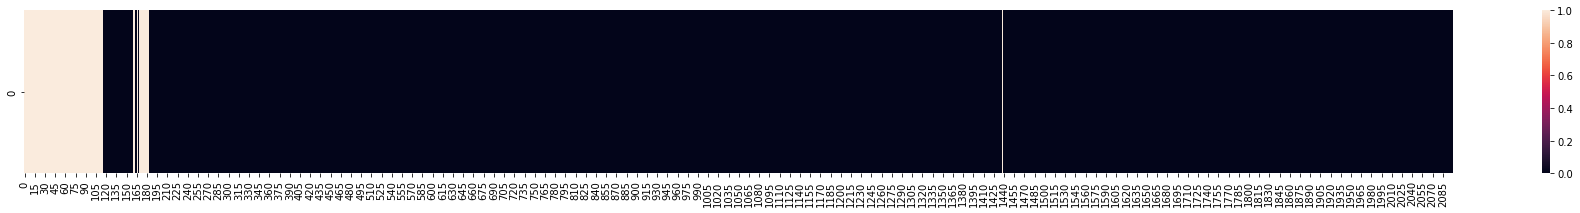

In [10]:
plt.figure(figsize=(32, 3))
sns.heatmap([df['reviewed']])

In [9]:
non_reviewed_tasks = collapse_consecutive_values(df[df['reviewed'] == False]['task_id'].sort_values())
for nrt_id, nrt_count in non_reviewed_tasks:
    print("{} - {} ({})".format(nrt_id, nrt_id + nrt_count - 1, nrt_count))
print("{} total tasks not reviewed".format(sum([nrt[1] for nrt in non_reviewed_tasks])))

81 - 96 (16)
98 - 104 (7)
106 - 110 (5)
112 - 117 (6)
119 - 485 (367)
487 - 497 (11)
499 - 509 (11)
511 - 571 (61)
573 - 589 (17)
591 - 769 (179)
771 - 777 (7)
779 - 787 (9)
789 - 1044 (256)
1046 - 1132 (87)
1134 - 1148 (15)
1150 - 1192 (43)
1194 - 1244 (51)
1246 - 1282 (37)
1284 - 1434 (151)
1436 - 1436 (1)
1439 - 1439 (1)
1441 - 1441 (1)
1443 - 1443 (1)
1448 - 1449 (2)
1452 - 1452 (1)
1454 - 1454 (1)
1456 - 1456 (1)
1458 - 1475 (18)
1477 - 1540 (64)
1542 - 1563 (22)
1565 - 1567 (3)
1569 - 1571 (3)
1573 - 1587 (15)
1589 - 1595 (7)
1597 - 1610 (14)
1612 - 1626 (15)
1628 - 1653 (26)
1655 - 1672 (18)
1674 - 1681 (8)
1683 - 1691 (9)
1693 - 1723 (31)
1725 - 1727 (3)
1729 - 1732 (4)
1734 - 1744 (11)
1746 - 1771 (26)
1773 - 1785 (13)
1787 - 1887 (101)
1889 - 1915 (27)
1917 - 1975 (59)
1977 - 2025 (49)
2027 - 2100 (74)
1965 total tasks not reviewed


In [10]:
df['reviewed'].to_numpy().nonzero()[0]

array([   0,    1,    2, ..., 2366, 2375, 2376], dtype=int64)